Today we'll be continuing with the dataset that we worked with in Day 3.

Day 3 (Preprocessing) introduced some preprocessing steps that allowed us to detect the cell bodies and nuclei by making masks of the actin and DAPI channels. In that case, we had a very clear sense of whether our preprocessing steps were "working" using visual inspection of the mask as a quality control. 

Our end goal is to quantify the change in nuclear localization and amount of your favorite protein with drug treatment. We would like to be able to answer two questions: 

1) Does the *total* amount of protein per cell change with drug treatment and 

2) How does the localization change between the nucleus and the cytplasm? 

Addressing these questions requires care when choosing the preprocessing algorithms to apply and their ordering, as well as batch processing across datasets.


## Pipeline design: ordering steps for fluorescence quantification

Let's pull in the data from yesterday and make the mask as we did earlier...

In [12]:
%matplotlib inline

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
sns.set_style('dark', rc={'image.cmap':'inferno'})

In [15]:
from skimage.io import imread

data_drug = imread("../data/confocal_drug_panel/drugA.tif")
data_nodrug = imread("../data/confocal_drug_panel/DMSO.tif")

In [16]:
import json
with open('../data/confocal_drug_panel/DMSO_metadata.json', mode='r') as f_nodrug:
    meta_nodrug = json.load(f_nodrug)

for key, value in meta_nodrug.items():
    print(key)

drug_slice = {}
nodrug_slice = {}
for idx, channel in enumerate(meta_nodrug['channels']):
    drug_slice[channel] = data_drug[3,:,:,idx]
    nodrug_slice[channel] = data_nodrug[3,:,:,idx] #add in the indexing when read in full dataset
    print(channel)

cell_type
channels
raw_data_date
image_preprocessing_done
pixel_size
axes
your_fav_protein
nucleus
actin


Always look at your data... (even though you just did yesterday)

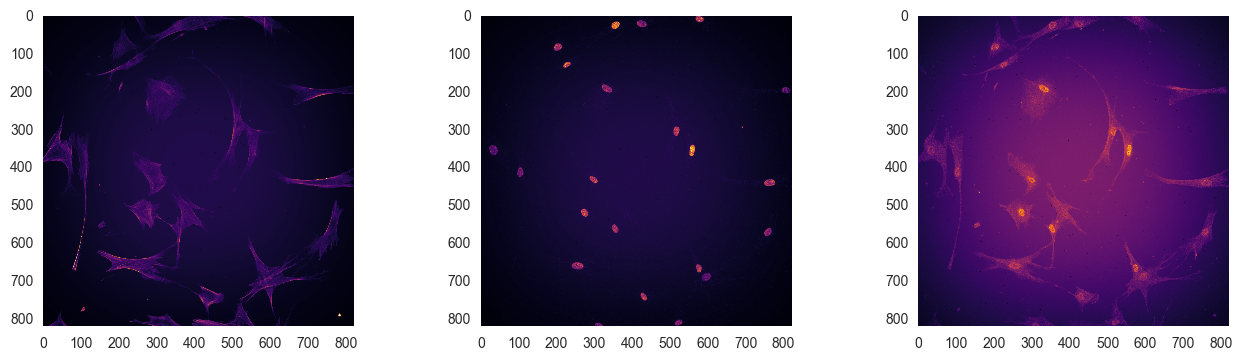

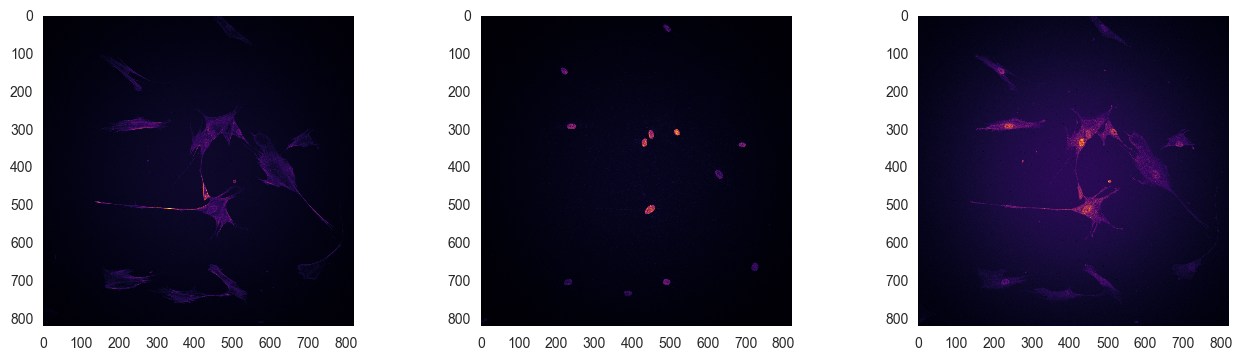

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(nodrug_slice["actin"])
ax[1].imshow(nodrug_slice['nucleus'])
ax[2].imshow(nodrug_slice["your_fav_protein"])

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(drug_slice["actin"])
ax[1].imshow(drug_slice['nucleus'])
ax[2].imshow(drug_slice["your_fav_protein"])

As we learnt yesterday, we'll make a mask by median filtering, then making a mask using the threshold given by Otsu's method, and finally, perform some morphological operations to make our masks look decent. We'll do both the actin and nucleus channels together this time...

In [18]:
from scipy.ndimage.filters import median_filter
from skimage import filters
import skimage.morphology as sm

channels_of_interest = ['actin', 'nucleus'] # Don't do anything to your_fav_protein!!
median_filter_size = 2
data = drug_slice
drug_masks = {}

for channel in channels_of_interest:
    original = data[channel].copy() # No need to start over-writing things...
    filtered = median_filter(original, size=median_filter_size)
    otsu_thresh = filters.threshold_otsu(filtered)
    masked = filtered > otsu_thresh

    morph1 = sm.binary_closing(masked,sm.disk(3))
    morph2 = sm.binary_opening(morph1,sm.disk(3))
    drug_masks[channel] = morph2

You should take a look at what happened...

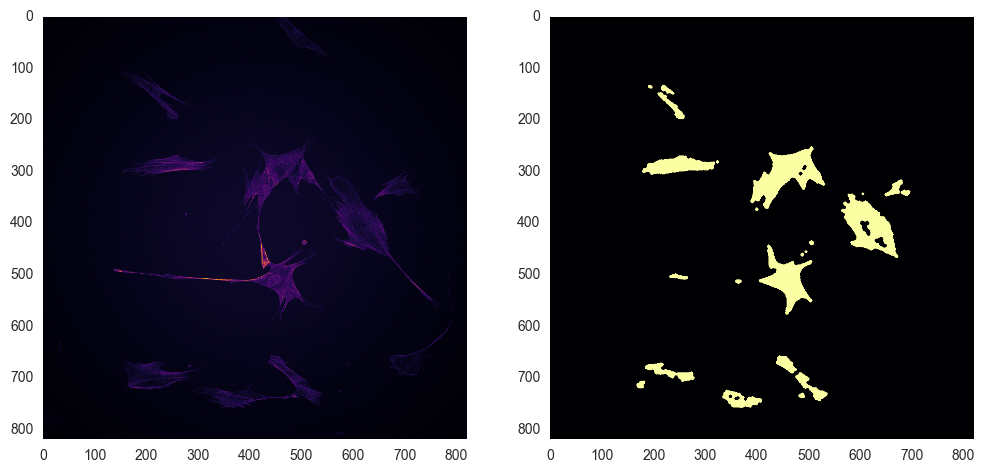

In [23]:
ch = 'actin'
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(drug_slice[ch])
ax[1].imshow(drug_masks[ch])

At this point, we've converted both our "actin" and "nucleus" channels to binary masks. Let's now make a "cell body" mask that has the cells but not the nuclei.

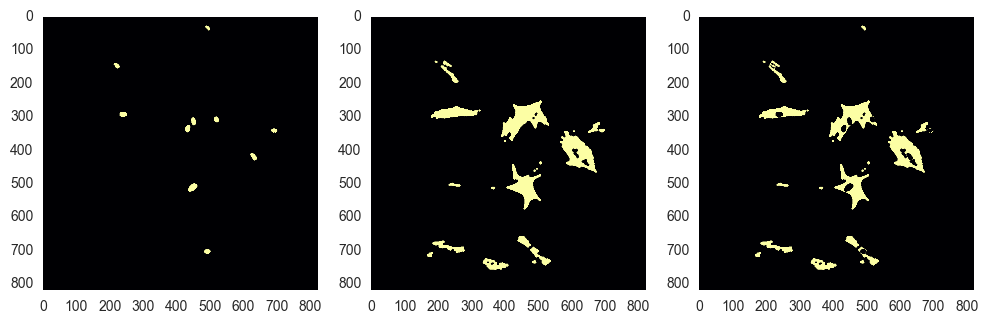

In [24]:
drug_masks['cell_body'] = drug_masks['actin'] ^ drug_masks['nucleus'] # ^ is essentially a minus sign

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(drug_masks['nucleus'])
ax[1].imshow(drug_masks['actin'])
ax[2].imshow(drug_masks['cell_body'])

Ugh, lots of unnecessary holes in the actin mask... We know what to do about that!

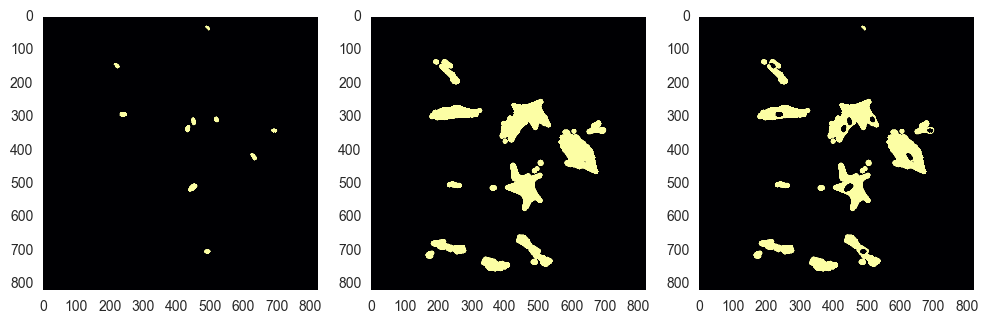

In [21]:
actin = drug_masks['actin'].copy()
nucleus = drug_masks['nucleus'].copy()
refined_actin_mask = sm.binary_dilation(actin, sm.disk(5))

refined_cell_body_mask= refined_actin_mask ^ nucleus

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(nucleus)
ax[1].imshow(refined_actin_mask)
ax[2].imshow(refined_cell_body_mask)

Close enough. Now let's calculate a mean cytoplasmic and nuclear intensities of *your_fav_protein*. For this, we'll apply our masks to the image of interest.

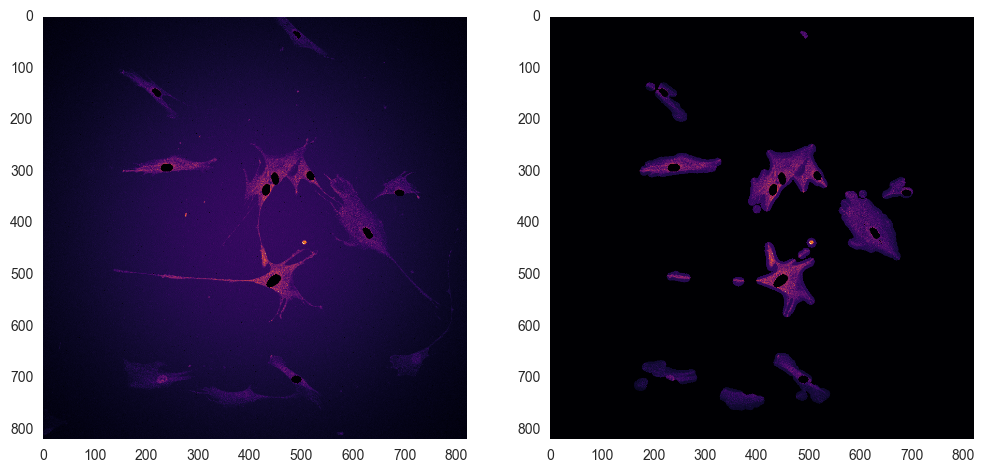

In [22]:
yfp = drug_slice['your_fav_protein']
inv_nucleus_mask = nucleus
inv_cell_body_mask = ~refined_cell_body_mask 

nuclear_intensities = yfp.copy()
nuclear_intensities[inv_nucleus_mask] = 0

cytoplasmic_intensities = yfp.copy()
cytoplasmic_intensities[inv_cell_body_mask] = 0

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(nuclear_intensities)
ax[1].imshow(cytoplasmic_intensities)

Now we can easily measure cytoplasmic and nuclear averages!